In [ ]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount = True)

Mounted at /content/gdrive


In [ ]:
import os
import time
import shutil
import random
import cv2
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
import tensorflow as tf
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.utils import *
from keras.callbacks import *
from keras.initializers import *
import tensorflow as tf
from keras.applications import vgg16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from keras.models import Model
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import classification_report
print("Tensorflow version " + tf.__version__)
from keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix, accuracy_score

from mlxtend.plotting import plot_confusion_matrix

Tensorflow version 2.9.2


In [ ]:
data = pd.read_csv('/content/gdrive/MyDrive/XLA/facial-expression-recognition-svm/fer2013.csv')
#check data shape
data.shape

(35887, 3)

In [ ]:
data.head(5)

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [ ]:
data.Usage.value_counts()

Training       28709
PublicTest      3589
PrivateTest     3589
Name: Usage, dtype: int64

In [ ]:
#check target labels
emotion_map = {0: 'Angry', 1: 'Digust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}
emotion_counts = data['emotion'].value_counts(sort=False).reset_index()
emotion_counts.columns = ['emotion', 'number']
emotion_counts['emotion'] = emotion_counts['emotion'].map(emotion_map)
emotion_counts

,emotion,number
0,Angry,4953
1,Fear,5121
2,Sad,6077
3,Neutral,6198
4,Happy,8989
5,Surprise,4002
6,Digust,547


/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


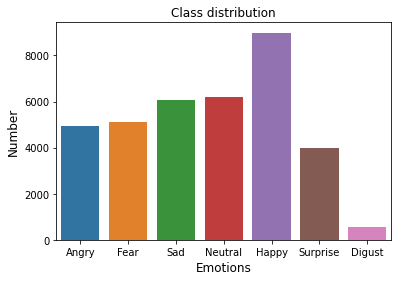

In [ ]:
# Plotting a bar graph of the class distributions
plt.figure(figsize=(6,4))
sns.barplot(emotion_counts.emotion, emotion_counts.number)
plt.title('Class distribution')
plt.ylabel('Number', fontsize=12)
plt.xlabel('Emotions', fontsize=12)
plt.show()

In [ ]:
CATEGORIES = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
X = []
y = []
for index, row in data.iterrows():
    try:
        pixels=np.asarray(list(row['pixels'].split(' ')), dtype=np.uint8)
        img = pixels.reshape((48,48))
        X.append(img)
        y.append(row['emotion'])
    except Exception as e:
        pass

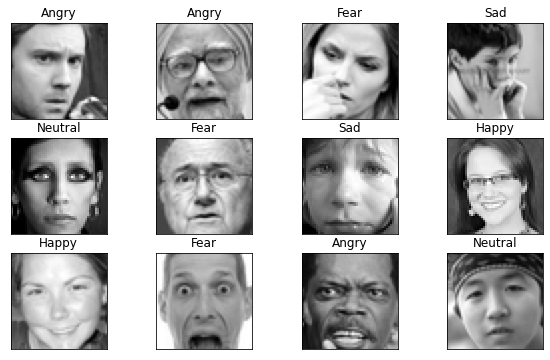

In [ ]:
fig=plt.figure(figsize=(10,6))

for counter, img in enumerate(X[:12]):
    ax = fig.add_subplot(3,4,counter+1)
    ax.imshow(X[counter], cmap='gray')
    plt.title(CATEGORIES[y[counter]])
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    
plt.show()

In [ ]:
X = np.array(X, dtype='float32').reshape(-1, 48, 48)
rgb_X = np.repeat(X[..., np.newaxis], 3, -1)
rgb_X=rgb_X/255.
y = np.asarray(y)
y.shape

(35887,)

In [ ]:
rgb_X.shape

(35887, 48, 48, 3)

In [ ]:
(X_train, X_val, y_train, y_val) = train_test_split(rgb_X, y,
                                                    test_size=0.2,
                                                    random_state=2022,
                                                    shuffle=True,
                                                    stratify=y)

In [ ]:
X_train.shape

(28709, 48, 48, 3)

In [ ]:
X_val.shape

(7178, 48, 48, 3)

In [ ]:
aug_train = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")

generator_val = ImageDataGenerator()

In [ ]:
aug_train.fit(X_train)

generator_val.fit(X_val)

In [ ]:
print(aug_train)

##VGG16

In [ ]:
IMG_WIDTH = 48
IMG_HEIGHT = 48

In [ ]:
model = Sequential()

pretrained_model = tf.keras.applications.VGG16(include_top=False, 
                                        input_shape=(IMG_WIDTH, IMG_HEIGHT, 3),classes=7,
                                        weights='imagenet')

pretrained_model.trainable=False

model.add(pretrained_model)
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.25))
# Output layer
model.add(Dense(7, activation='softmax'))
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0005),loss=tf.keras.losses.SparseCategoricalCrossentropy(),metrics=['accuracy'])
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten_4 (Flatten)         (None, 512)               0         
                                                                 
 dense_13 (Dense)            (None, 64)                32832     
                                                                 
 dropout_9 (Dropout)         (None, 64)                0         
                                                                 
 dense_14 (Dense)            (None, 32)                2080      
                                                                 
 dropout_10 (Dropout)        (None, 32)                0         
                                                                 
 dense_15 (Dense)            (None, 7)                

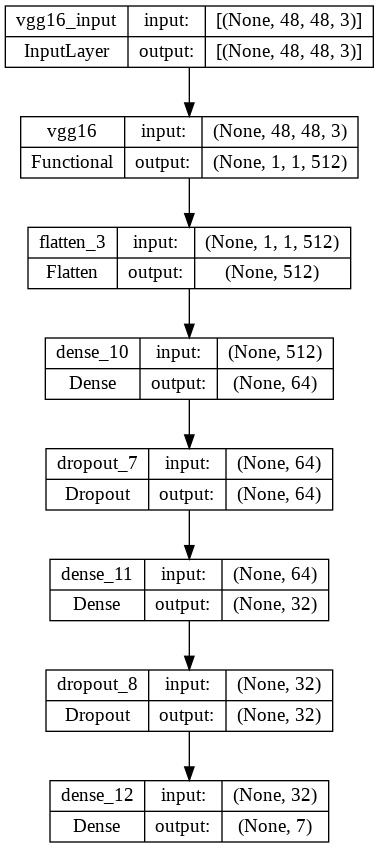

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)
#tf.keras.utils.plot_model(pretrained_model, show_shapes=True)

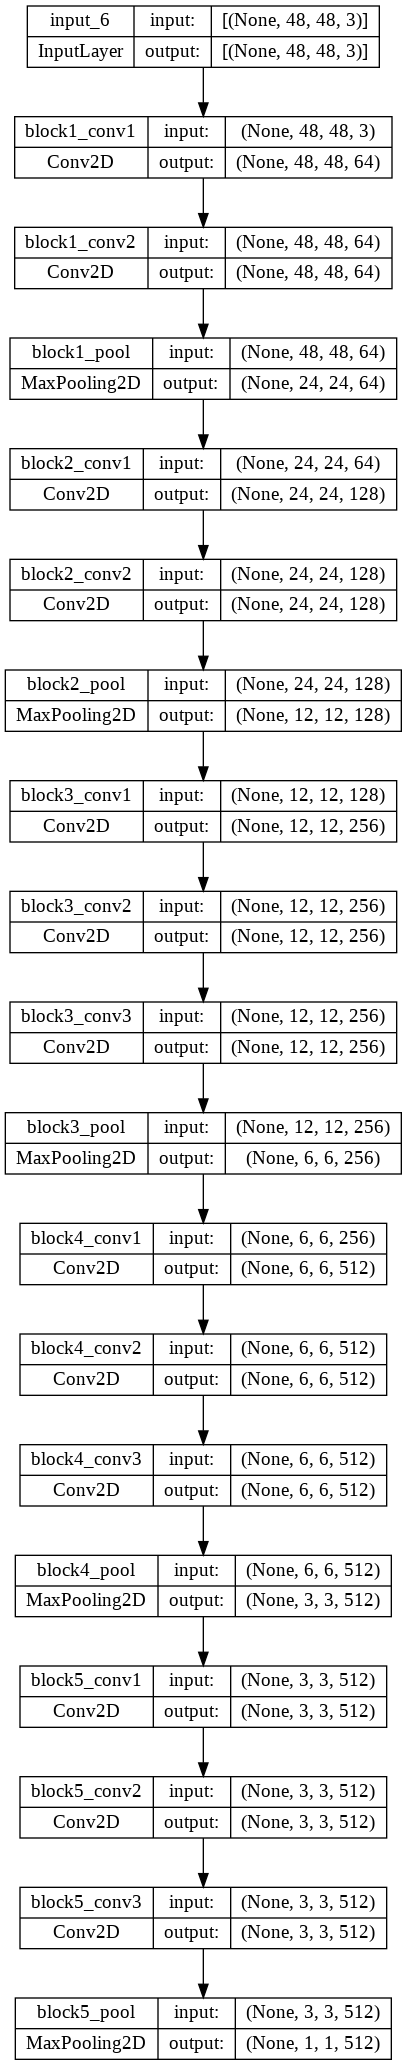

In [ ]:
tf.keras.utils.plot_model(pretrained_model, show_shapes=True)

In [ ]:
hist_path = '/content/gdrive/MyDrive/XLA/model/VGG16_Hist.log'
save_path = '/content/gdrive/MyDrive/XLA/model/VGG16.h5'

In [ ]:
#checkpoint
checkpoint = ModelCheckpoint(
    save_path,
    monitor = 'val_accuracy',
    mode = 'max',
    save_best_only = True,
    save_weights_only= False ,
    perior = 1,
    verbose = 1
)
#earlystopping
early_stopping = EarlyStopping(
    monitor = 'val_accuracy',
    mode = 'auto',
    min_delta = 0.0001,
    patience = 7,
    baseline = None,
    restore_best_weights = True,
    verbose = 1
)
#learning_rate_schedule
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [ ]:
history = model.fit(aug_train.flow(X_train, y_train, batch_size=32),
                    validation_data=generator_val.flow(X_val, y_val, batch_size=32),
                    steps_per_epoch=len(y_train) // 32,
                    epochs=50,
                    callbacks=[early_stopping, checkpoint, learning_rate_reduction, CSVLogger(hist_path)])

Epoch 1/50
896/897 [============================>.] - ETA: 0s - loss: 1.8120 - accuracy: 0.2436
Epoch 1: val_accuracy did not improve from 0.36431
897/897 [==============================] - 31s 34ms/step - loss: 1.8120 - accuracy: 0.2437 - val_loss: 1.7058 - val_accuracy: 0.2884 - lr: 5.0000e-04
Epoch 2/50
896/897 [============================>.] - ETA: 0s - loss: 1.7501 - accuracy: 0.2817
Epoch 2: val_accuracy did not improve from 0.36431
897/897 [==============================] - 30s 33ms/step - loss: 1.7502 - accuracy: 0.2817 - val_loss: 1.6744 - val_accuracy: 0.3288 - lr: 5.0000e-04
Epoch 3/50
896/897 [============================>.] - ETA: 0s - loss: 1.7280 - accuracy: 0.2981
Epoch 3: val_accuracy did not improve from 0.36431
897/897 [==============================] - 29s 32ms/step - loss: 1.7281 - accuracy: 0.2980 - val_loss: 1.6598 - val_accuracy: 0.3243 - lr: 5.0000e-04
Epoch 4/50
896/897 [============================>.] - ETA: 0s - loss: 1.7171 - accuracy: 0.3064
Epoch 4: val_

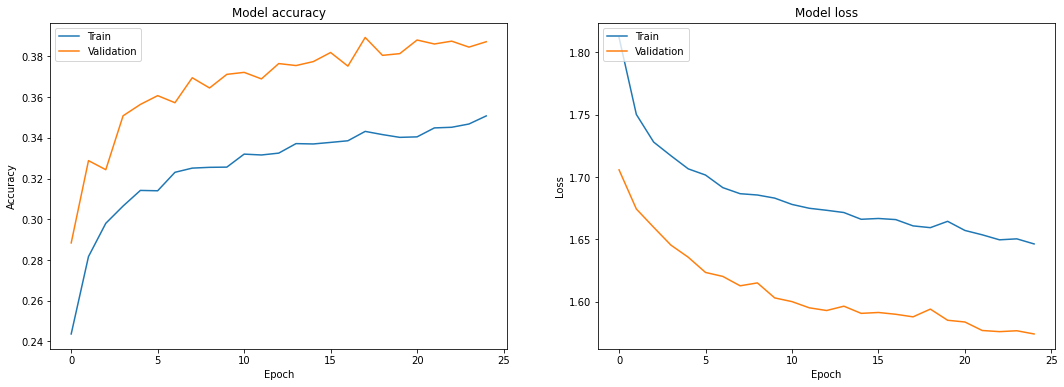

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(18, 6))
# Plot training & validation accuracy values
axes[0].plot(history.history['accuracy'])
axes[0].plot(history.history['val_accuracy'])
axes[0].set_title('Model accuracy')
axes[0].set_ylabel('Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
axes[1].plot(history.history['loss'])
axes[1].plot(history.history['val_loss'])
axes[1].set_title('Model loss')
axes[1].set_ylabel('Loss')
axes[1].set_xlabel('Epoch')
axes[1].legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [ ]:
for i in model.layers:
  i.trainable = True
model.compile(optimizer=Adam(learning_rate=0.000005),loss=tf.keras.losses.SparseCategoricalCrossentropy(),metrics=['accuracy'])
model.summary()
history1 = model.fit(aug_train.flow(X_train, y_train, batch_size=32),
                    validation_data=generator_val.flow(X_val, y_val, batch_size=32),
                    steps_per_epoch=len(y_train) // 32,
                    epochs=50)
                    # callbacks=[early_stopping, checkpoint, learning_rate_reduction, CSVLogger(hist_path)])

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten_4 (Flatten)         (None, 512)               0         
                                                                 
 dense_13 (Dense)            (None, 64)                32832     
                                                                 
 dropout_9 (Dropout)         (None, 64)                0         
                                                                 
 dense_14 (Dense)            (None, 32)                2080      
                                                                 
 dropout_10 (Dropout)        (None, 32)                0         
                                                                 
 dense_15 (Dense)            (None, 7)                

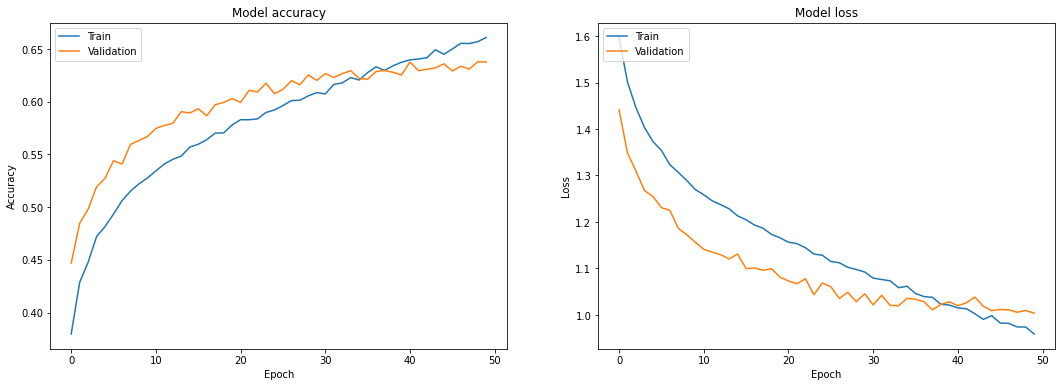

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(18, 6))
# Plot training & validation accuracy values
axes[0].plot(history1.history['accuracy'])
axes[0].plot(history1.history['val_accuracy'])
axes[0].set_title('Model accuracy')
axes[0].set_ylabel('Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
axes[1].plot(history1.history['loss'])
axes[1].plot(history1.history['val_loss'])
axes[1].set_title('Model loss')
axes[1].set_ylabel('Loss')
axes[1].set_xlabel('Epoch')
axes[1].legend(['Train', 'Validation'], loc='upper left')
plt.show()


225/225 [==============================] - 4s 13ms/step


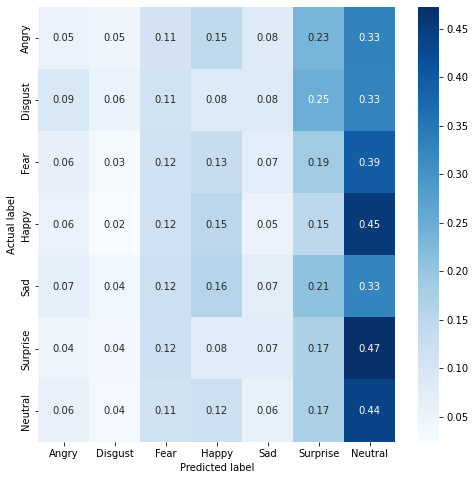

In [ ]:
predicted_label = model.predict(X_val)
predicted_label = np.argmax(predicted_label, axis = 1)
cm = confusion_matrix(y_val, predicted_label)
#Normalise
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(cmn, annot=True, fmt='.2f', cmap=plt.cm.Blues, xticklabels=CATEGORIES, yticklabels=CATEGORIES)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show(block=False)